In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),}


data_dir = 'Fish'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets['test'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


['Common_roach', 'Grass_carp', 'Ruffe']


In [6]:
#Model loading
model = torch.load('Effb2_model.pth', map_location=device)
model = model.to(device)
model.eval()

print("Model loaded and set to evaluation mode.")

C:\Users\pogra\AppData\Local\Temp\ipykernel_15076\2923788088.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('Effb2_model.pth', map_location=device)


Model loaded and set to evaluation mode.


In [9]:
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Legvalószínűbb osztály
        _, preds = torch.max(outputs, 1)

        # Softmax valószínűségek
        probs = F.softmax(outputs, dim=1)

        for i in range(inputs.size(0)):
            print(f"\n🖼️ Picture {i+1}:")
            print(f"True label: {class_names[labels[i]]}")
            print(f"Predicted: {class_names[preds[i]]}")
            print("Probabilities:")
            for j, p in enumerate(probs[i]):
                print(f"  {class_names[j]}: {p.item()*100:.2f}%")



🖼️ Picture 1:
True label: Common_roach
Predicted: Common_roach
Probabilities:
  Common_roach: 95.26%
  Grass_carp: 0.61%
  Ruffe: 4.13%

🖼️ Picture 2:
True label: Ruffe
Predicted: Ruffe
Probabilities:
  Common_roach: 6.37%
  Grass_carp: 3.43%
  Ruffe: 90.20%

🖼️ Picture 3:
True label: Common_roach
Predicted: Common_roach
Probabilities:
  Common_roach: 86.66%
  Grass_carp: 1.72%
  Ruffe: 11.62%

🖼️ Picture 4:
True label: Common_roach
Predicted: Common_roach
Probabilities:
  Common_roach: 99.99%
  Grass_carp: 0.01%
  Ruffe: 0.00%

🖼️ Picture 1:
True label: Common_roach
Predicted: Common_roach
Probabilities:
  Common_roach: 99.97%
  Grass_carp: 0.02%
  Ruffe: 0.01%

🖼️ Picture 2:
True label: Ruffe
Predicted: Ruffe
Probabilities:
  Common_roach: 0.69%
  Grass_carp: 1.24%
  Ruffe: 98.07%

🖼️ Picture 3:
True label: Common_roach
Predicted: Common_roach
Probabilities:
  Common_roach: 71.94%
  Grass_carp: 27.30%
  Ruffe: 0.76%

🖼️ Picture 4:
True label: Ruffe
Predicted: Ruffe
Probabilities:
  

In [10]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Confusion matrix:
[[146   5   1]
 [  3 115   1]
 [  3   2 148]]


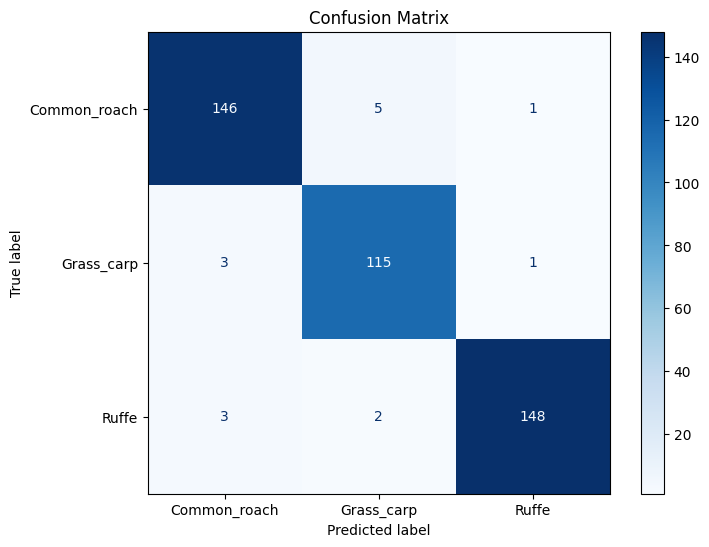

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:")
print(cm)

#Plot graphs
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix")
plt.show()


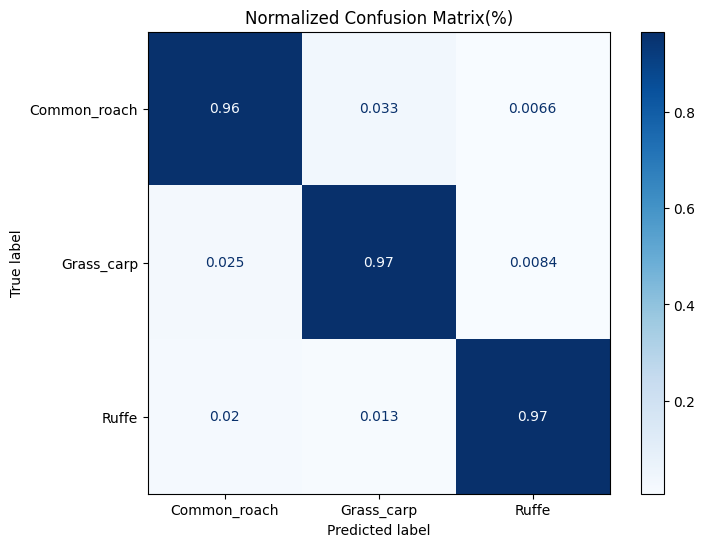

In [13]:
cm_normalized = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Normalized Confusion Matrix(%)")
plt.show()
